In [1]:
import json
import random
import helper
import models
import pickle
import numpy as np
import pandas as pd
import importlib as imp
from datetime import datetime
from matplotlib import pyplot as plt
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, utils

rs = 2018
random.seed(rs)

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.width = 1000

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
use_cuda = torch.cuda.is_available()
print('Using cuda: {}'.format(use_cuda))
torch.manual_seed(rs)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 100

Using cuda: False


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=True, split='digits', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader_ordered = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=len(test_loader.dataset), shuffle=False, **kwargs)

In [5]:
fours = np.load('files_for_comparison/digits4.npz')
sevens = np.load('files_for_comparison/digits7.npz')
eights = np.load('files_for_comparison/digits8.npz')

indices = {
    4: {
        'ix1':fours['ix1'],
        'ix2':fours['ix2']
    },
    7: {
        'ix1':sevens['ix1'],
        'ix2':sevens['ix2']
    },
    8: {
        'ix1':eights['ix1'],
        'ix2':eights['ix2']
    }
}

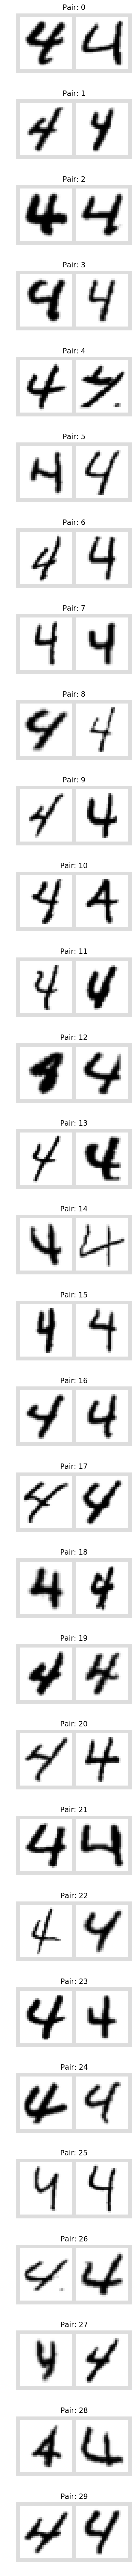

In [6]:
testiter = iter(test_loader_ordered)
images, target = testiter.next()
images = helper.rotate(images, cuda=use_cuda)

helper.plot_image_pairs(images[torch.LongTensor(indices[4]['ix1'])], images[torch.LongTensor(indices[4]['ix2'])])


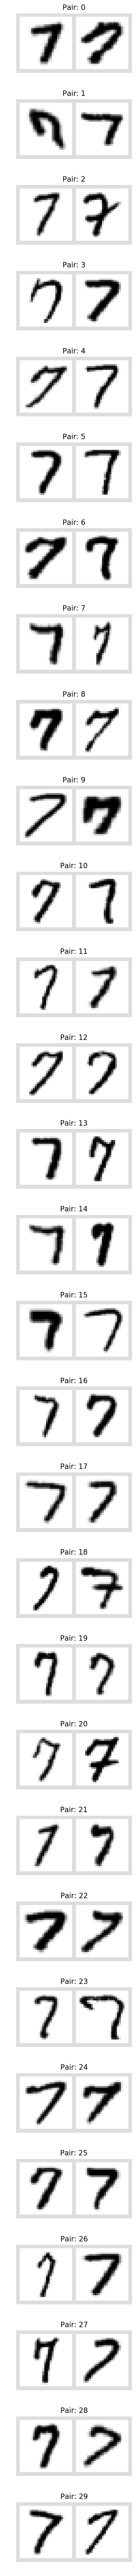

In [7]:
helper.plot_image_pairs(images[torch.LongTensor(indices[7]['ix1'])], images[torch.LongTensor(indices[7]['ix2'])])


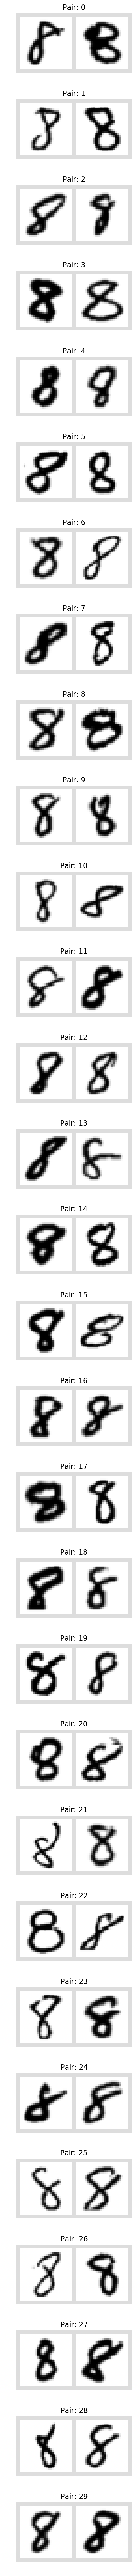

In [8]:
helper.plot_image_pairs(images[torch.LongTensor(indices[8]['ix1'])], images[torch.LongTensor(indices[8]['ix2'])])


In [9]:
data_df = pd.read_csv('results/pytorch_results.csv')
print(data_df.columns.tolist())
for l in range(1,5):
    print(data_df[data_df.layers==l].sort_values(by='accuracy', ascending=False).head(1).values[0].tolist())

['batch_size', 'layers', 'dropout_rate', 'n_filters', 'filter_size', 'fc_units', 'epoch', 'train_time', 'test_loss', 'accuracy']
[100, 1, 0.2, 10, 5, 100, 15, '0 days 00:12:48.673449000', 0.03253963649272919, 0.9903]
[100, 2, 0.2, 16, 5, 50, 15, '0 days 00:12:42.133719000', 0.02724303795993328, 0.991825]
[100, 3, 0.2, 16, 5, 50, 15, '0 days 00:12:47.853331000', 0.027311920815706246, 0.99185]
[100, 4, 0.2, 16, 5, 100, 15, '0 days 00:13:31.713766000', 0.026011360847949985, 0.9924]


In [10]:
batch_size=100

train_loader = torch.utils.data.DataLoader(
        datasets.EMNIST('data/', train=True, split='digits', download=True,
            transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
            batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', 
        transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
        batch_size=batch_size, shuffle=True, **kwargs)

args = {1: {'dropout_rate':0.2, 'n_filters':10, 'filter_size':5, 'fc_units':100, 'epoch':15},
        2: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':50, 'epoch':15},
        3: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':50, 'epoch':15},
        4: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':100, 'epoch':15},
       }

models_list = []
for layers, ar in args.items():
    print('-------------------------------------------------------------\n')
    print('Training best {0:d} layer CNN with dropout={1:1.1f}, n_filters={2:d}, filter_size={3:d}, fc_units={4:d}'.format(layers,ar[[*ar][0]],ar[[*ar][1]],ar[[*ar][2]],ar[[*ar][3]]))
    start = datetime.now()
    model = models.get_model(layers, 
                             dropout_rate=ar['dropout_rate'], 
                             n_filters=ar['n_filters'], 
                             filter_size=ar['filter_size'], 
                             fc_units=ar['fc_units'])
    if use_cuda:
        model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
    for e in range(1,ar['epoch']+1):
        print(e,'of',ar['epoch'], 'epochs')
        models.train(model, optimizer, train_loader, use_cuda, device, e, layers=layers)
        elapsed = datetime.now() - start
        print('Time elapsed {}'.format(elapsed))
        test_loss, correct = models.test(model, optimizer, test_loader, use_cuda, device, e, layers=layers)
    
    models_list.append(model)
Net1, Net2, Net3, Net4 = models_list

-------------------------------------------------------------

Training best 1 layer CNN with dropout=0.2, n_filters=10, filter_size=5, fc_units=100
1 of 15 epochs
Train Epoch: 1 [0/240000 (0%)]	Loss: 2.286615
Train Epoch: 1 [1000/240000 (0%)]	Loss: 2.281867
Train Epoch: 1 [2000/240000 (1%)]	Loss: 2.270783
Train Epoch: 1 [3000/240000 (1%)]	Loss: 2.259045
Train Epoch: 1 [4000/240000 (2%)]	Loss: 2.242230
Train Epoch: 1 [5000/240000 (2%)]	Loss: 2.251663
Train Epoch: 1 [6000/240000 (2%)]	Loss: 2.186541
Train Epoch: 1 [7000/240000 (3%)]	Loss: 2.182662
Train Epoch: 1 [8000/240000 (3%)]	Loss: 2.149285
Train Epoch: 1 [9000/240000 (4%)]	Loss: 2.179808
Train Epoch: 1 [10000/240000 (4%)]	Loss: 2.128983
Train Epoch: 1 [11000/240000 (5%)]	Loss: 2.114856
Train Epoch: 1 [12000/240000 (5%)]	Loss: 2.093755
Train Epoch: 1 [13000/240000 (5%)]	Loss: 2.073034
Train Epoch: 1 [14000/240000 (6%)]	Loss: 2.051335
Train Epoch: 1 [15000/240000 (6%)]	Loss: 2.057367
Train Epoch: 1 [16000/240000 (7%)]	Loss: 2.015130

Train Epoch: 1 [158000/240000 (66%)]	Loss: 0.270477
Train Epoch: 1 [159000/240000 (66%)]	Loss: 0.295130
Train Epoch: 1 [160000/240000 (67%)]	Loss: 0.289981
Train Epoch: 1 [161000/240000 (67%)]	Loss: 0.429641
Train Epoch: 1 [162000/240000 (68%)]	Loss: 0.347705
Train Epoch: 1 [163000/240000 (68%)]	Loss: 0.321030
Train Epoch: 1 [164000/240000 (68%)]	Loss: 0.377620
Train Epoch: 1 [165000/240000 (69%)]	Loss: 0.226185
Train Epoch: 1 [166000/240000 (69%)]	Loss: 0.326994
Train Epoch: 1 [167000/240000 (70%)]	Loss: 0.329378
Train Epoch: 1 [168000/240000 (70%)]	Loss: 0.333235
Train Epoch: 1 [169000/240000 (70%)]	Loss: 0.377660
Train Epoch: 1 [170000/240000 (71%)]	Loss: 0.363725
Train Epoch: 1 [171000/240000 (71%)]	Loss: 0.231578
Train Epoch: 1 [172000/240000 (72%)]	Loss: 0.230432
Train Epoch: 1 [173000/240000 (72%)]	Loss: 0.289182
Train Epoch: 1 [174000/240000 (72%)]	Loss: 0.297311
Train Epoch: 1 [175000/240000 (73%)]	Loss: 0.379605
Train Epoch: 1 [176000/240000 (73%)]	Loss: 0.289253
Train Epoch:

Train Epoch: 2 [76000/240000 (32%)]	Loss: 0.320373
Train Epoch: 2 [77000/240000 (32%)]	Loss: 0.301774
Train Epoch: 2 [78000/240000 (32%)]	Loss: 0.301828
Train Epoch: 2 [79000/240000 (33%)]	Loss: 0.321417
Train Epoch: 2 [80000/240000 (33%)]	Loss: 0.167922
Train Epoch: 2 [81000/240000 (34%)]	Loss: 0.139919
Train Epoch: 2 [82000/240000 (34%)]	Loss: 0.142170
Train Epoch: 2 [83000/240000 (35%)]	Loss: 0.230041
Train Epoch: 2 [84000/240000 (35%)]	Loss: 0.260576
Train Epoch: 2 [85000/240000 (35%)]	Loss: 0.288112
Train Epoch: 2 [86000/240000 (36%)]	Loss: 0.257926
Train Epoch: 2 [87000/240000 (36%)]	Loss: 0.244884
Train Epoch: 2 [88000/240000 (37%)]	Loss: 0.157432
Train Epoch: 2 [89000/240000 (37%)]	Loss: 0.229249
Train Epoch: 2 [90000/240000 (38%)]	Loss: 0.227993
Train Epoch: 2 [91000/240000 (38%)]	Loss: 0.293104
Train Epoch: 2 [92000/240000 (38%)]	Loss: 0.201623
Train Epoch: 2 [93000/240000 (39%)]	Loss: 0.173803
Train Epoch: 2 [94000/240000 (39%)]	Loss: 0.320620
Train Epoch: 2 [95000/240000 (4

Train Epoch: 2 [235000/240000 (98%)]	Loss: 0.190825
Train Epoch: 2 [236000/240000 (98%)]	Loss: 0.242259
Train Epoch: 2 [237000/240000 (99%)]	Loss: 0.213797
Train Epoch: 2 [238000/240000 (99%)]	Loss: 0.181827
Train Epoch: 2 [239000/240000 (100%)]	Loss: 0.171825
Time elapsed 0:03:26.870434

Test set: Average loss: 0.1764, Accuracy: 37909.0/40000 (95%)

3 of 15 epochs
Train Epoch: 3 [0/240000 (0%)]	Loss: 0.324889
Train Epoch: 3 [1000/240000 (0%)]	Loss: 0.100929
Train Epoch: 3 [2000/240000 (1%)]	Loss: 0.116105
Train Epoch: 3 [3000/240000 (1%)]	Loss: 0.197048
Train Epoch: 3 [4000/240000 (2%)]	Loss: 0.131414
Train Epoch: 3 [5000/240000 (2%)]	Loss: 0.283618
Train Epoch: 3 [6000/240000 (2%)]	Loss: 0.228503
Train Epoch: 3 [7000/240000 (3%)]	Loss: 0.200069
Train Epoch: 3 [8000/240000 (3%)]	Loss: 0.177340
Train Epoch: 3 [9000/240000 (4%)]	Loss: 0.249785
Train Epoch: 3 [10000/240000 (4%)]	Loss: 0.206193
Train Epoch: 3 [11000/240000 (5%)]	Loss: 0.170569
Train Epoch: 3 [12000/240000 (5%)]	Loss: 0.18

Train Epoch: 3 [154000/240000 (64%)]	Loss: 0.138523
Train Epoch: 3 [155000/240000 (65%)]	Loss: 0.162412
Train Epoch: 3 [156000/240000 (65%)]	Loss: 0.210158
Train Epoch: 3 [157000/240000 (65%)]	Loss: 0.173313
Train Epoch: 3 [158000/240000 (66%)]	Loss: 0.164447
Train Epoch: 3 [159000/240000 (66%)]	Loss: 0.175983
Train Epoch: 3 [160000/240000 (67%)]	Loss: 0.143432
Train Epoch: 3 [161000/240000 (67%)]	Loss: 0.170276
Train Epoch: 3 [162000/240000 (68%)]	Loss: 0.191389
Train Epoch: 3 [163000/240000 (68%)]	Loss: 0.241084
Train Epoch: 3 [164000/240000 (68%)]	Loss: 0.174645
Train Epoch: 3 [165000/240000 (69%)]	Loss: 0.187258
Train Epoch: 3 [166000/240000 (69%)]	Loss: 0.111676
Train Epoch: 3 [167000/240000 (70%)]	Loss: 0.298839
Train Epoch: 3 [168000/240000 (70%)]	Loss: 0.121557
Train Epoch: 3 [169000/240000 (70%)]	Loss: 0.151957
Train Epoch: 3 [170000/240000 (71%)]	Loss: 0.149750
Train Epoch: 3 [171000/240000 (71%)]	Loss: 0.160254
Train Epoch: 3 [172000/240000 (72%)]	Loss: 0.195253
Train Epoch:

Train Epoch: 4 [72000/240000 (30%)]	Loss: 0.124136
Train Epoch: 4 [73000/240000 (30%)]	Loss: 0.217790
Train Epoch: 4 [74000/240000 (31%)]	Loss: 0.153320
Train Epoch: 4 [75000/240000 (31%)]	Loss: 0.220181
Train Epoch: 4 [76000/240000 (32%)]	Loss: 0.179070
Train Epoch: 4 [77000/240000 (32%)]	Loss: 0.152840
Train Epoch: 4 [78000/240000 (32%)]	Loss: 0.213002
Train Epoch: 4 [79000/240000 (33%)]	Loss: 0.158765
Train Epoch: 4 [80000/240000 (33%)]	Loss: 0.149108
Train Epoch: 4 [81000/240000 (34%)]	Loss: 0.091783
Train Epoch: 4 [82000/240000 (34%)]	Loss: 0.176914
Train Epoch: 4 [83000/240000 (35%)]	Loss: 0.309105
Train Epoch: 4 [84000/240000 (35%)]	Loss: 0.141852
Train Epoch: 4 [85000/240000 (35%)]	Loss: 0.069624
Train Epoch: 4 [86000/240000 (36%)]	Loss: 0.281638
Train Epoch: 4 [87000/240000 (36%)]	Loss: 0.161799
Train Epoch: 4 [88000/240000 (37%)]	Loss: 0.218233
Train Epoch: 4 [89000/240000 (37%)]	Loss: 0.165052
Train Epoch: 4 [90000/240000 (38%)]	Loss: 0.131218
Train Epoch: 4 [91000/240000 (3

Train Epoch: 4 [231000/240000 (96%)]	Loss: 0.098884
Train Epoch: 4 [232000/240000 (97%)]	Loss: 0.135440
Train Epoch: 4 [233000/240000 (97%)]	Loss: 0.185023
Train Epoch: 4 [234000/240000 (98%)]	Loss: 0.220785
Train Epoch: 4 [235000/240000 (98%)]	Loss: 0.246316
Train Epoch: 4 [236000/240000 (98%)]	Loss: 0.073222
Train Epoch: 4 [237000/240000 (99%)]	Loss: 0.138446
Train Epoch: 4 [238000/240000 (99%)]	Loss: 0.186680
Train Epoch: 4 [239000/240000 (100%)]	Loss: 0.070112
Time elapsed 0:07:11.668715

Test set: Average loss: 0.1187, Accuracy: 38592.0/40000 (96%)

5 of 15 epochs
Train Epoch: 5 [0/240000 (0%)]	Loss: 0.192033
Train Epoch: 5 [1000/240000 (0%)]	Loss: 0.123074
Train Epoch: 5 [2000/240000 (1%)]	Loss: 0.090761
Train Epoch: 5 [3000/240000 (1%)]	Loss: 0.099566
Train Epoch: 5 [4000/240000 (2%)]	Loss: 0.129843
Train Epoch: 5 [5000/240000 (2%)]	Loss: 0.107736
Train Epoch: 5 [6000/240000 (2%)]	Loss: 0.146204
Train Epoch: 5 [7000/240000 (3%)]	Loss: 0.196235
Train Epoch: 5 [8000/240000 (3%)]	L

Train Epoch: 5 [150000/240000 (62%)]	Loss: 0.065308
Train Epoch: 5 [151000/240000 (63%)]	Loss: 0.138559
Train Epoch: 5 [152000/240000 (63%)]	Loss: 0.164135
Train Epoch: 5 [153000/240000 (64%)]	Loss: 0.127705
Train Epoch: 5 [154000/240000 (64%)]	Loss: 0.098917
Train Epoch: 5 [155000/240000 (65%)]	Loss: 0.126355
Train Epoch: 5 [156000/240000 (65%)]	Loss: 0.099451
Train Epoch: 5 [157000/240000 (65%)]	Loss: 0.111384
Train Epoch: 5 [158000/240000 (66%)]	Loss: 0.125975
Train Epoch: 5 [159000/240000 (66%)]	Loss: 0.071152
Train Epoch: 5 [160000/240000 (67%)]	Loss: 0.135303
Train Epoch: 5 [161000/240000 (67%)]	Loss: 0.065600
Train Epoch: 5 [162000/240000 (68%)]	Loss: 0.081191
Train Epoch: 5 [163000/240000 (68%)]	Loss: 0.161783
Train Epoch: 5 [164000/240000 (68%)]	Loss: 0.135457
Train Epoch: 5 [165000/240000 (69%)]	Loss: 0.099641
Train Epoch: 5 [166000/240000 (69%)]	Loss: 0.150525
Train Epoch: 5 [167000/240000 (70%)]	Loss: 0.070420
Train Epoch: 5 [168000/240000 (70%)]	Loss: 0.136874
Train Epoch:

Train Epoch: 6 [68000/240000 (28%)]	Loss: 0.055380
Train Epoch: 6 [69000/240000 (29%)]	Loss: 0.202005
Train Epoch: 6 [70000/240000 (29%)]	Loss: 0.103339
Train Epoch: 6 [71000/240000 (30%)]	Loss: 0.137420
Train Epoch: 6 [72000/240000 (30%)]	Loss: 0.036120
Train Epoch: 6 [73000/240000 (30%)]	Loss: 0.053831
Train Epoch: 6 [74000/240000 (31%)]	Loss: 0.059623
Train Epoch: 6 [75000/240000 (31%)]	Loss: 0.132775
Train Epoch: 6 [76000/240000 (32%)]	Loss: 0.101755
Train Epoch: 6 [77000/240000 (32%)]	Loss: 0.155582
Train Epoch: 6 [78000/240000 (32%)]	Loss: 0.197090
Train Epoch: 6 [79000/240000 (33%)]	Loss: 0.047228
Train Epoch: 6 [80000/240000 (33%)]	Loss: 0.143400
Train Epoch: 6 [81000/240000 (34%)]	Loss: 0.123681
Train Epoch: 6 [82000/240000 (34%)]	Loss: 0.146371
Train Epoch: 6 [83000/240000 (35%)]	Loss: 0.090687
Train Epoch: 6 [84000/240000 (35%)]	Loss: 0.080244
Train Epoch: 6 [85000/240000 (35%)]	Loss: 0.210609
Train Epoch: 6 [86000/240000 (36%)]	Loss: 0.094147
Train Epoch: 6 [87000/240000 (3

Train Epoch: 6 [227000/240000 (95%)]	Loss: 0.138574
Train Epoch: 6 [228000/240000 (95%)]	Loss: 0.128962
Train Epoch: 6 [229000/240000 (95%)]	Loss: 0.140877
Train Epoch: 6 [230000/240000 (96%)]	Loss: 0.087776
Train Epoch: 6 [231000/240000 (96%)]	Loss: 0.167287
Train Epoch: 6 [232000/240000 (97%)]	Loss: 0.136386
Train Epoch: 6 [233000/240000 (97%)]	Loss: 0.101197
Train Epoch: 6 [234000/240000 (98%)]	Loss: 0.155634
Train Epoch: 6 [235000/240000 (98%)]	Loss: 0.154877
Train Epoch: 6 [236000/240000 (98%)]	Loss: 0.105951
Train Epoch: 6 [237000/240000 (99%)]	Loss: 0.075819
Train Epoch: 6 [238000/240000 (99%)]	Loss: 0.100093
Train Epoch: 6 [239000/240000 (100%)]	Loss: 0.105152
Time elapsed 0:09:50.405772

Test set: Average loss: 0.0909, Accuracy: 38952.0/40000 (97%)

7 of 15 epochs
Train Epoch: 7 [0/240000 (0%)]	Loss: 0.100304
Train Epoch: 7 [1000/240000 (0%)]	Loss: 0.126821
Train Epoch: 7 [2000/240000 (1%)]	Loss: 0.067567
Train Epoch: 7 [3000/240000 (1%)]	Loss: 0.115624
Train Epoch: 7 [4000/24

Train Epoch: 7 [146000/240000 (61%)]	Loss: 0.035441
Train Epoch: 7 [147000/240000 (61%)]	Loss: 0.073329
Train Epoch: 7 [148000/240000 (62%)]	Loss: 0.167898
Train Epoch: 7 [149000/240000 (62%)]	Loss: 0.093146
Train Epoch: 7 [150000/240000 (62%)]	Loss: 0.112901
Train Epoch: 7 [151000/240000 (63%)]	Loss: 0.096530
Train Epoch: 7 [152000/240000 (63%)]	Loss: 0.114095
Train Epoch: 7 [153000/240000 (64%)]	Loss: 0.086708
Train Epoch: 7 [154000/240000 (64%)]	Loss: 0.056262
Train Epoch: 7 [155000/240000 (65%)]	Loss: 0.071992
Train Epoch: 7 [156000/240000 (65%)]	Loss: 0.056592
Train Epoch: 7 [157000/240000 (65%)]	Loss: 0.075213
Train Epoch: 7 [158000/240000 (66%)]	Loss: 0.073204
Train Epoch: 7 [159000/240000 (66%)]	Loss: 0.122281
Train Epoch: 7 [160000/240000 (67%)]	Loss: 0.201970
Train Epoch: 7 [161000/240000 (67%)]	Loss: 0.078318
Train Epoch: 7 [162000/240000 (68%)]	Loss: 0.061459
Train Epoch: 7 [163000/240000 (68%)]	Loss: 0.077678
Train Epoch: 7 [164000/240000 (68%)]	Loss: 0.049904
Train Epoch:

Train Epoch: 8 [64000/240000 (27%)]	Loss: 0.103962
Train Epoch: 8 [65000/240000 (27%)]	Loss: 0.059245
Train Epoch: 8 [66000/240000 (28%)]	Loss: 0.113843
Train Epoch: 8 [67000/240000 (28%)]	Loss: 0.059068
Train Epoch: 8 [68000/240000 (28%)]	Loss: 0.103229
Train Epoch: 8 [69000/240000 (29%)]	Loss: 0.081078
Train Epoch: 8 [70000/240000 (29%)]	Loss: 0.063434
Train Epoch: 8 [71000/240000 (30%)]	Loss: 0.171830
Train Epoch: 8 [72000/240000 (30%)]	Loss: 0.084277
Train Epoch: 8 [73000/240000 (30%)]	Loss: 0.079449
Train Epoch: 8 [74000/240000 (31%)]	Loss: 0.143678
Train Epoch: 8 [75000/240000 (31%)]	Loss: 0.104303
Train Epoch: 8 [76000/240000 (32%)]	Loss: 0.064241
Train Epoch: 8 [77000/240000 (32%)]	Loss: 0.056084
Train Epoch: 8 [78000/240000 (32%)]	Loss: 0.071607
Train Epoch: 8 [79000/240000 (33%)]	Loss: 0.030780
Train Epoch: 8 [80000/240000 (33%)]	Loss: 0.098776
Train Epoch: 8 [81000/240000 (34%)]	Loss: 0.088668
Train Epoch: 8 [82000/240000 (34%)]	Loss: 0.175886
Train Epoch: 8 [83000/240000 (3

Train Epoch: 8 [223000/240000 (93%)]	Loss: 0.142278
Train Epoch: 8 [224000/240000 (93%)]	Loss: 0.080702
Train Epoch: 8 [225000/240000 (94%)]	Loss: 0.057332
Train Epoch: 8 [226000/240000 (94%)]	Loss: 0.155605
Train Epoch: 8 [227000/240000 (95%)]	Loss: 0.074401
Train Epoch: 8 [228000/240000 (95%)]	Loss: 0.057910
Train Epoch: 8 [229000/240000 (95%)]	Loss: 0.110815
Train Epoch: 8 [230000/240000 (96%)]	Loss: 0.087741
Train Epoch: 8 [231000/240000 (96%)]	Loss: 0.133267
Train Epoch: 8 [232000/240000 (97%)]	Loss: 0.036593
Train Epoch: 8 [233000/240000 (97%)]	Loss: 0.061896
Train Epoch: 8 [234000/240000 (98%)]	Loss: 0.106175
Train Epoch: 8 [235000/240000 (98%)]	Loss: 0.030868
Train Epoch: 8 [236000/240000 (98%)]	Loss: 0.080076
Train Epoch: 8 [237000/240000 (99%)]	Loss: 0.091465
Train Epoch: 8 [238000/240000 (99%)]	Loss: 0.078144
Train Epoch: 8 [239000/240000 (100%)]	Loss: 0.112917
Time elapsed 0:12:02.590790

Test set: Average loss: 0.0748, Accuracy: 39167.0/40000 (98%)

9 of 15 epochs
Train Ep

Train Epoch: 9 [142000/240000 (59%)]	Loss: 0.087321
Train Epoch: 9 [143000/240000 (60%)]	Loss: 0.080246
Train Epoch: 9 [144000/240000 (60%)]	Loss: 0.085898
Train Epoch: 9 [145000/240000 (60%)]	Loss: 0.067573
Train Epoch: 9 [146000/240000 (61%)]	Loss: 0.088138
Train Epoch: 9 [147000/240000 (61%)]	Loss: 0.153212
Train Epoch: 9 [148000/240000 (62%)]	Loss: 0.067511
Train Epoch: 9 [149000/240000 (62%)]	Loss: 0.124139
Train Epoch: 9 [150000/240000 (62%)]	Loss: 0.027266
Train Epoch: 9 [151000/240000 (63%)]	Loss: 0.048897
Train Epoch: 9 [152000/240000 (63%)]	Loss: 0.081161
Train Epoch: 9 [153000/240000 (64%)]	Loss: 0.056780
Train Epoch: 9 [154000/240000 (64%)]	Loss: 0.043538
Train Epoch: 9 [155000/240000 (65%)]	Loss: 0.060861
Train Epoch: 9 [156000/240000 (65%)]	Loss: 0.103322
Train Epoch: 9 [157000/240000 (65%)]	Loss: 0.060890
Train Epoch: 9 [158000/240000 (66%)]	Loss: 0.045256
Train Epoch: 9 [159000/240000 (66%)]	Loss: 0.039387
Train Epoch: 9 [160000/240000 (67%)]	Loss: 0.036364
Train Epoch:

Train Epoch: 10 [59000/240000 (25%)]	Loss: 0.101539
Train Epoch: 10 [60000/240000 (25%)]	Loss: 0.067071
Train Epoch: 10 [61000/240000 (25%)]	Loss: 0.080945
Train Epoch: 10 [62000/240000 (26%)]	Loss: 0.088098
Train Epoch: 10 [63000/240000 (26%)]	Loss: 0.057391
Train Epoch: 10 [64000/240000 (27%)]	Loss: 0.166867
Train Epoch: 10 [65000/240000 (27%)]	Loss: 0.175671
Train Epoch: 10 [66000/240000 (28%)]	Loss: 0.047505
Train Epoch: 10 [67000/240000 (28%)]	Loss: 0.060963
Train Epoch: 10 [68000/240000 (28%)]	Loss: 0.169152
Train Epoch: 10 [69000/240000 (29%)]	Loss: 0.033022
Train Epoch: 10 [70000/240000 (29%)]	Loss: 0.049828
Train Epoch: 10 [71000/240000 (30%)]	Loss: 0.055162
Train Epoch: 10 [72000/240000 (30%)]	Loss: 0.076663
Train Epoch: 10 [73000/240000 (30%)]	Loss: 0.090433
Train Epoch: 10 [74000/240000 (31%)]	Loss: 0.075867
Train Epoch: 10 [75000/240000 (31%)]	Loss: 0.060523
Train Epoch: 10 [76000/240000 (32%)]	Loss: 0.077891
Train Epoch: 10 [77000/240000 (32%)]	Loss: 0.076490
Train Epoch:

Train Epoch: 10 [215000/240000 (90%)]	Loss: 0.145234
Train Epoch: 10 [216000/240000 (90%)]	Loss: 0.221464
Train Epoch: 10 [217000/240000 (90%)]	Loss: 0.060665
Train Epoch: 10 [218000/240000 (91%)]	Loss: 0.130709
Train Epoch: 10 [219000/240000 (91%)]	Loss: 0.044153
Train Epoch: 10 [220000/240000 (92%)]	Loss: 0.044276
Train Epoch: 10 [221000/240000 (92%)]	Loss: 0.095485
Train Epoch: 10 [222000/240000 (92%)]	Loss: 0.091502
Train Epoch: 10 [223000/240000 (93%)]	Loss: 0.046303
Train Epoch: 10 [224000/240000 (93%)]	Loss: 0.059869
Train Epoch: 10 [225000/240000 (94%)]	Loss: 0.099763
Train Epoch: 10 [226000/240000 (94%)]	Loss: 0.085851
Train Epoch: 10 [227000/240000 (95%)]	Loss: 0.091394
Train Epoch: 10 [228000/240000 (95%)]	Loss: 0.102482
Train Epoch: 10 [229000/240000 (95%)]	Loss: 0.081817
Train Epoch: 10 [230000/240000 (96%)]	Loss: 0.216547
Train Epoch: 10 [231000/240000 (96%)]	Loss: 0.041504
Train Epoch: 10 [232000/240000 (97%)]	Loss: 0.067628
Train Epoch: 10 [233000/240000 (97%)]	Loss: 0.

Train Epoch: 11 [131000/240000 (55%)]	Loss: 0.069553
Train Epoch: 11 [132000/240000 (55%)]	Loss: 0.101552
Train Epoch: 11 [133000/240000 (55%)]	Loss: 0.102293
Train Epoch: 11 [134000/240000 (56%)]	Loss: 0.048896
Train Epoch: 11 [135000/240000 (56%)]	Loss: 0.063388
Train Epoch: 11 [136000/240000 (57%)]	Loss: 0.041813
Train Epoch: 11 [137000/240000 (57%)]	Loss: 0.087191
Train Epoch: 11 [138000/240000 (58%)]	Loss: 0.071062
Train Epoch: 11 [139000/240000 (58%)]	Loss: 0.053926
Train Epoch: 11 [140000/240000 (58%)]	Loss: 0.085792
Train Epoch: 11 [141000/240000 (59%)]	Loss: 0.097916
Train Epoch: 11 [142000/240000 (59%)]	Loss: 0.045195
Train Epoch: 11 [143000/240000 (60%)]	Loss: 0.121283
Train Epoch: 11 [144000/240000 (60%)]	Loss: 0.120715
Train Epoch: 11 [145000/240000 (60%)]	Loss: 0.096962
Train Epoch: 11 [146000/240000 (61%)]	Loss: 0.111486
Train Epoch: 11 [147000/240000 (61%)]	Loss: 0.076266
Train Epoch: 11 [148000/240000 (62%)]	Loss: 0.041049
Train Epoch: 11 [149000/240000 (62%)]	Loss: 0.

Train Epoch: 12 [46000/240000 (19%)]	Loss: 0.030440
Train Epoch: 12 [47000/240000 (20%)]	Loss: 0.079765
Train Epoch: 12 [48000/240000 (20%)]	Loss: 0.088251
Train Epoch: 12 [49000/240000 (20%)]	Loss: 0.054116
Train Epoch: 12 [50000/240000 (21%)]	Loss: 0.070080
Train Epoch: 12 [51000/240000 (21%)]	Loss: 0.091419
Train Epoch: 12 [52000/240000 (22%)]	Loss: 0.064223
Train Epoch: 12 [53000/240000 (22%)]	Loss: 0.059961
Train Epoch: 12 [54000/240000 (22%)]	Loss: 0.119852
Train Epoch: 12 [55000/240000 (23%)]	Loss: 0.021478
Train Epoch: 12 [56000/240000 (23%)]	Loss: 0.058363
Train Epoch: 12 [57000/240000 (24%)]	Loss: 0.063030
Train Epoch: 12 [58000/240000 (24%)]	Loss: 0.157011
Train Epoch: 12 [59000/240000 (25%)]	Loss: 0.026962
Train Epoch: 12 [60000/240000 (25%)]	Loss: 0.112612
Train Epoch: 12 [61000/240000 (25%)]	Loss: 0.173357
Train Epoch: 12 [62000/240000 (26%)]	Loss: 0.087129
Train Epoch: 12 [63000/240000 (26%)]	Loss: 0.050347
Train Epoch: 12 [64000/240000 (27%)]	Loss: 0.068756
Train Epoch:

Train Epoch: 12 [202000/240000 (84%)]	Loss: 0.068291
Train Epoch: 12 [203000/240000 (85%)]	Loss: 0.073780
Train Epoch: 12 [204000/240000 (85%)]	Loss: 0.043108
Train Epoch: 12 [205000/240000 (85%)]	Loss: 0.092207
Train Epoch: 12 [206000/240000 (86%)]	Loss: 0.065380
Train Epoch: 12 [207000/240000 (86%)]	Loss: 0.080018
Train Epoch: 12 [208000/240000 (87%)]	Loss: 0.027142
Train Epoch: 12 [209000/240000 (87%)]	Loss: 0.094490
Train Epoch: 12 [210000/240000 (88%)]	Loss: 0.053618
Train Epoch: 12 [211000/240000 (88%)]	Loss: 0.018143
Train Epoch: 12 [212000/240000 (88%)]	Loss: 0.124564
Train Epoch: 12 [213000/240000 (89%)]	Loss: 0.087577
Train Epoch: 12 [214000/240000 (89%)]	Loss: 0.118621
Train Epoch: 12 [215000/240000 (90%)]	Loss: 0.089452
Train Epoch: 12 [216000/240000 (90%)]	Loss: 0.132660
Train Epoch: 12 [217000/240000 (90%)]	Loss: 0.084970
Train Epoch: 12 [218000/240000 (91%)]	Loss: 0.045944
Train Epoch: 12 [219000/240000 (91%)]	Loss: 0.081926
Train Epoch: 12 [220000/240000 (92%)]	Loss: 0.

KeyboardInterrupt: 

In [11]:
args = {1: {'dropout_rate':0.2, 'n_filters':10, 'filter_size':5, 'fc_units':100, 'epoch':15},
       2: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':50, 'epoch':15},
       3: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':50, 'epoch':15},
       4: {'dropout_rate':0.2, 'n_filters':16, 'filter_size':5, 'fc_units':100, 'epoch':15},
      }

Net1 = models.get_model(1,
                        dropout_rate=args[1]['dropout_rate'],
                        n_filters=args[1]['n_filters'],
                        filter_size=args[1]['filter_size'],
                        fc_units=args[1]['fc_units'])
Net1.load_state_dict(torch.load('best_models/CNN_'+str(1)+'_layers', map_location='cpu'))

Net2 = models.get_model(2,
                        dropout_rate=args[2]['dropout_rate'],
                        n_filters=args[2]['n_filters'],
                        filter_size=args[2]['filter_size'],
                        fc_units=args[2]['fc_units'])
Net2.load_state_dict(torch.load('best_models/CNN_'+str(2)+'_layers', map_location='cpu'))

Net3 = models.get_model(3,
                        dropout_rate=args[3]['dropout_rate'],
                        n_filters=args[3]['n_filters'],
                        filter_size=args[3]['filter_size'],
                        fc_units=args[3]['fc_units'])
Net3.load_state_dict(torch.load('best_models/CNN_'+str(3)+'_layers', map_location='cpu'))

Net4 = models.get_model(4,
                        dropout_rate=args[4]['dropout_rate'],
                        n_filters=args[4]['n_filters'],
                        filter_size=args[4]['filter_size'],
                        fc_units=args[4]['fc_units'])
Net4.load_state_dict(torch.load('best_models/CNN_'+str(4)+'_layers', map_location='cpu'))